In [9]:
#Install uninstalled modules, comment if it's already installed

#%pip install -U MetaTrader5 matplotlib numpy pandas pandas_ta pickle scikit-learn

In [10]:
#Python version
!python --version

Python 3.8.12


In [30]:
#Import needed modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from finta import TA

from datetime import datetime
import os, pytz
import MetaTrader5 as mt5

import config

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle

In [12]:
#HYPER PARAMETER

In [13]:
#Trading Account Parameter
account = config.username   #Account number
password = config.password  #Password number
server = config.mt5_server  #Server name
path = config.mt5_path      #path of Metatrader5 director

mt5.initialize(
   path = path,          # path to the MetaTrader 5 terminal EXE file
   login = account,      # account number
   password = password,  # password
   server = server,      # server name as it is specified in the terminal
   #timeout = TIMEOUT,   # timeout
   portable = False      # portable mode
   )

# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__,"\n")

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize failed, error code =",mt5.last_error())
    mt5.shutdown()
else:
    print("MetaTrader5 Initialized!")
    account_info_dict = mt5.account_info()._asdict()
    acc_info = pd.DataFrame(list(account_info_dict.items()),columns=['property','value'])
    print("\n", "account_info() as dataframe:")
    print(acc_info)

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.36 

MetaTrader5 Initialized!

 account_info() as dataframe:
              property             value
0                login            647479
1           trade_mode                 0
2             leverage              1000
3         limit_orders               100
4       margin_so_mode                 0
5        trade_allowed              True
6         trade_expert              True
7          margin_mode                 2
8      currency_digits                 2
9           fifo_close             False
10             balance          99993.72
11              credit               0.0
12              profit               0.0
13              equity          99993.72
14              margin               0.0
15         margin_free          99993.72
16        margin_level               0.0
17      margin_so_call              40.0
18        margin_so_so              20.0
19      margin_initial               0.0

In [14]:
#Extract Account info from dataframe
leverage = acc_info.loc[2, "value"]
balance = acc_info.loc[10, "value"]
profit = acc_info.loc[12, "value"]
equity = acc_info.loc[13, "value"]
margin_free = acc_info.loc[15, "value"]

print(leverage)
print(balance)
print(profit)
print(equity)
print(margin_free)

1000
99993.72
0.0
99993.72
99993.72


Small Note, in terminal in `trade_allowed` variable = false in sunday

In [15]:
terminal_info_dict = mt5.terminal_info()._asdict()
terminal_info = pd.DataFrame(list(terminal_info_dict.items()),columns=['property','value'])
print("\n", "account_info() as dataframe:")
print(terminal_info)


 account_info() as dataframe:
                 property                                              value
0       community_account                                               True
1    community_connection                                               True
2               connected                                               True
3            dlls_allowed                                              False
4           trade_allowed                                              False
5       tradeapi_disabled                                              False
6           email_enabled                                              False
7             ftp_enabled                                              False
8   notifications_enabled                                              False
9                    mqid                                               True
10                  build                                               3137
11                maxbars                    

In [16]:
trade_allowed = terminal_info.loc[4, "value"]
print(trade_allowed)

False


In [130]:
# set time zone to UTC
timezone = pytz.timezone("Etc/UTC")
symbol = 'EURUSD'
timeframe = mt5.TIMEFRAME_M5
bars = 75000

def get_price(symbol, timeframe, bars):
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, bars + 1)

    # create DataFrame out of the obtained data
    rates_frame = pd.DataFrame(rates, dtype=np.dtype("float"))

    # convert time in seconds into the datetime format
    rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
    rates_frame = rates_frame.rename(columns={'tick_volume': 'volume'})
    del rates_frame['real_volume']

    rates_frame = rates_frame.set_index('time')

    return rates_frame

rates_frame = get_price(symbol, timeframe, bars)                             
# display data
print("\nDisplay dataframe with data")
rates_frame.tail()


Display dataframe with data


,open,high,low,close,volume,spread
time,,,,,,
2022-01-10 10:00:00,1.13281,1.13300,1.13251,1.13271,196.0,10.0
2022-01-10 10:05:00,1.13271,1.13286,1.13209,1.13227,228.0,10.0
2022-01-10 10:10:00,1.13228,1.13245,1.13196,1.13227,219.0,10.0
2022-01-10 10:15:00,1.13222,1.13250,1.13198,1.13248,242.0,10.0
2022-01-10 10:20:00,1.13248,1.13274,1.13236,1.13237,256.0,10.0


In [18]:
symbol_info = mt5.symbol_info(symbol)
if symbol_info!=None:
    # display the terminal data 'as is'    
    #print(symbol_info)
    print("\n","{}:".format(symbol))
    print("spread =",symbol_info.spread,", digits =",symbol_info.digits, "\n")
    print("swap long =", symbol_info.swap_long, "\n")
    print ("------------------------------")
else:
    print("There is no such symbol of {}".format(symbol))


 EURUSD:
spread = 10 , digits = 5 

swap long = -6.37 

------------------------------


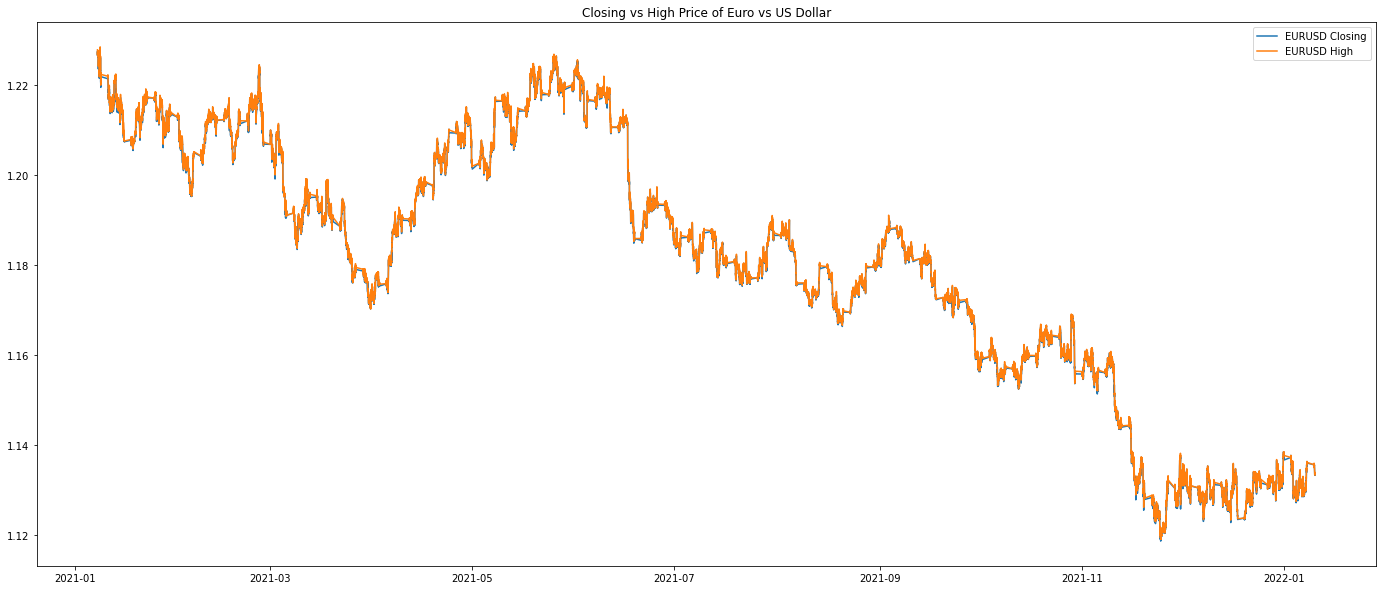

In [19]:
def plotClosing(df):
    plt.figure(figsize=(24,10))
    plt.plot(df.close, label='{} Closing'.format(symbol))
    plt.plot(df.high, label='{} High'.format(symbol))
    plt.title('Closing vs High Price of {}'.format(symbol_info.description))
    plt.legend()
    plt.show()

plotClosing(rates_frame)

In [20]:
def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low", "volume")
    Returns:
        dataframe, data set with new features
    Timeframe for calculation:
        6 timeframe for 30 minutes
        48 timeframe for 4 hours
        144 timeframe for 12 hours
        288 timeframe for 1 day
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    df_new['open'] = df['open']
    df_new['open_5m'] = df['open'].shift(1)
    df_new['close_5m'] = df['close'].shift(1)
    df_new['high_5m'] = df['high'].shift(1)
    df_new['low_5m'] = df['low'].shift(1)
    df_new['volume_5m'] = df['volume'].shift(1)
    df_new['spread_5m'] = df['spread'].shift(1)
    
    # 50 original features
    # average price
    df_new['avg_price_30m'] = df['close'].rolling(window=6).mean().shift(1)
    df_new['avg_price_4h'] = df['close'].rolling(window=48).mean().shift(1)
    df_new['avg_price_12h'] = df['close'].rolling(window=144).mean().shift(1)
    df_new['avg_price_1d'] = df['close'].rolling(window=288).mean().shift(1)
    
    # average price ratio
    df_new['ratio_avg_price_30m_4h'] = df_new['avg_price_30m'] / df_new['avg_price_4h']
    df_new['ratio_avg_price_30m_12h'] = df_new['avg_price_30m'] / df_new['avg_price_12h']
    df_new['ratio_avg_price_30m_1d'] = df_new['avg_price_30m'] / df_new['avg_price_1d']
    df_new['ratio_avg_price_4h_12h'] = df_new['avg_price_4h'] / df_new['avg_price_12h']
    df_new['ratio_avg_price_4h_1d'] = df_new['avg_price_4h'] / df_new['avg_price_1d']
    df_new['ratio_avg_price_12h_1d'] = df_new['avg_price_12h'] / df_new['avg_price_1d']                                            
    
    
    # average volume
    df_new['avg_volume_30m'] = df['volume'].rolling(window=6).mean().shift(1)
    df_new['avg_volume_4h'] = df['volume'].rolling(window=48).mean().shift(1)
    df_new['avg_volume_12h'] = df['volume'].rolling(window=144).mean().shift(1)
    df_new['avg_volume_1d'] = df['volume'].rolling(window=288).mean().shift(1)
    
    # average volume ratio
    df_new['ratio_avg_volume_30m_4h'] = df_new['avg_volume_30m'] / df_new['avg_volume_4h']
    df_new['ratio_avg_volumee_30m_12h'] = df_new['avg_volume_30m'] / df_new['avg_volume_12h']                                                   
    df_new['ratio_avg_volume_30m_1d'] = df_new['avg_volume_30m'] / df_new['avg_volume_1d']
    df_new['ratio_avg_volume_4h_12h'] = df_new['avg_volume_4h'] / df_new['avg_volume_12h']
    df_new['ratio_avg_volume_4h_1d'] = df_new['avg_volume_4h'] / df_new['avg_volume_1d']
    df_new['ratio_avg_volume_12h_1d'] = df_new['avg_volume_12h'] / df_new['avg_volume_1d']                                                 
    
    
    # standard deviation of prices
    df_new['std_price_30m'] = df['close'].rolling(window=6).std().shift(1)
    df_new['std_price_4h'] = df['close'].rolling(window=48).std().shift(1)
    df_new['std_price_12h'] = df['close'].rolling(window=144).std().shift(1)                                               
    df_new['std_price_1d'] = df['close'].rolling(window=288).std().shift(1)
    
    # standard deviation ratio of prices 
    df_new['ratio_std_price_30m_4h'] = df_new['std_price_30m'] / df_new['std_price_4h']
    df_new['ratio_std_price_30m_12h'] = df_new['std_price_30m'] / df_new['std_price_12h']
    df_new['ratio_std_price_30m_1d'] = df_new['std_price_30m'] / df_new['std_price_1d']
    df_new['ratio_std_price_4h_12h'] = df_new['std_price_4h'] / df_new['std_price_12h'] 
    df_new['ratio_std_price_3h_1d'] = df_new['std_price_4h'] / df_new['std_price_1d']                                               
    df_new['ratio_std_price_12h_1d'] = df_new['std_price_12h'] / df_new['std_price_1d']                                                
    
    
    # standard deviation of volumes
    df_new['std_volume_30m'] = df['volume'].rolling(window=6).std().shift(1)
    df_new['std_volume_4h'] = df['volume'].rolling(window=48).std().shift(1)
    df_new['std_volume_12h'] = df['volume'].rolling(window=144).std().shift(1)
    df_new['std_volume_1d'] = df['volume'].rolling(window=288).std().shift(1)
    
    # standard deviation ratio of volumes
    df_new['ratio_std_volume_30m_4h'] = df_new['std_volume_30m'] / df_new['std_volume_4h']
    df_new['ratio_std_volume_30m_12h'] = df_new['std_volume_30m'] / df_new['std_volume_12h']
    df_new['ratio_std_volume_30m_1d'] = df_new['std_volume_30m'] / df_new['std_volume_1d']
    df_new['ratio_std_volume_4h_12h'] = df_new['std_volume_4h'] / df_new['std_volume_12h'] 
    df_new['ratio_std_volume_3h_1d'] = df_new['std_volume_4h'] / df_new['std_volume_1d']                                               
    df_new['ratio_std_volume_12h_1d'] = df_new['std_volume_12h'] / df_new['std_volume_1d']                                               
                                                   
    # return
    df_new['return_5m'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
    df_new['return_30m'] = ((df['close'] - df['close'].shift(6)) / df['close'].shift(6)).shift(1)
    df_new['return_4h'] = ((df['close'] - df['close'].shift(48)) / df['close'].shift(48)).shift(1)
    df_new['return_12h'] = ((df['close'] - df['close'].shift(144)) / df['close'].shift(144)).shift(1)                                                
    df_new['return_1d'] = ((df['close'] - df['close'].shift(288)) / df['close'].shift(288)).shift(1)
    
    # average of return
    df_new['return_avg_30m'] = df_new['return_5m'].rolling(window=6).mean()
    df_new['return_avg_4h'] = df_new['return_5m'].rolling(window=48).mean()
    df_new['return_avg_12h'] = df_new['return_5m'].rolling(window=144).mean()
    df_new['return_avg_1d'] = df_new['return_5m'].rolling(window=288).mean()

    # indicator
    df_new['EMA_4h'] = TA.EMA(df, 48)

    # the target
    df_new['close'] = df['close']
    df_new = df_new.dropna(axis=0)
    return df_new

df = generate_features(rates_frame)
df.tail()

,open,open_5m,close_5m,high_5m,low_5m,volume_5m,spread_5m,avg_price_30m,avg_price_4h,avg_price_12h,...,return_30m,return_4h,return_12h,return_1d,return_avg_30m,return_avg_4h,return_avg_12h,return_avg_1d,EMA_4h,close
time,,,,,,,,,,,,,,,,,,,,,
2022-01-10 06:40:00,1.13360,1.13356,1.13360,1.13364,1.13355,17.0,11.0,1.133583,1.134417,1.135220,...,-0.000185,-0.001744,-0.000837,0.003221,-0.000031,-0.000036,-0.000006,0.000011,1.134192,1.13360
2022-01-10 06:45:00,1.13360,1.13360,1.13360,1.13362,1.13355,22.0,10.0,1.133563,1.134374,1.135213,...,-0.000106,-0.001814,-0.000899,0.003097,-0.000018,-0.000038,-0.000006,0.000011,1.134164,1.13351
2022-01-10 06:50:00,1.13351,1.13360,1.13351,1.13360,1.13351,45.0,10.0,1.133548,1.134335,1.135205,...,-0.000079,-0.001665,-0.001040,0.002964,-0.000013,-0.000035,-0.000007,0.000010,1.134128,1.13328
2022-01-10 06:55:00,1.13328,1.13351,1.13328,1.13351,1.13326,73.0,11.0,1.133502,1.134289,1.135194,...,-0.000247,-0.001920,-0.001392,0.002761,-0.000041,-0.000040,-0.000010,0.000010,1.134094,1.13331
2022-01-10 07:00:00,1.13331,1.13328,1.13331,1.13331,1.13322,37.0,10.0,1.133477,1.134246,1.135178,...,-0.000132,-0.001832,-0.001973,0.002956,-0.000022,-0.000038,-0.000014,0.000010,1.134062,1.13331


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74712 entries, 2021-01-08 20:55:00 to 2022-01-10 07:00:00
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   open                       74712 non-null  float64
 1   open_5m                    74712 non-null  float64
 2   close_5m                   74712 non-null  float64
 3   high_5m                    74712 non-null  float64
 4   low_5m                     74712 non-null  float64
 5   volume_5m                  74712 non-null  float64
 6   spread_5m                  74712 non-null  float64
 7   avg_price_30m              74712 non-null  float64
 8   avg_price_4h               74712 non-null  float64
 9   avg_price_12h              74712 non-null  float64
 10  avg_price_1d               74712 non-null  float64
 11  ratio_avg_price_30m_4h     74712 non-null  float64
 12  ratio_avg_price_30m_12h    74712 non-null  float64
 13  ratio_avg_p

In [22]:
X = df.drop('close', axis='columns')
y = df.close

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(52298, 57)
(22414, 57)
(52298,)
(22414,)


In [23]:
#initiating standard scaler
scaler = StandardScaler()

#fit the scaler in training features
scaler.fit(X_train)

#Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [24]:
lin = LinearRegression()

lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)

'''
Score Criteria (theoratically):
    RMSE = closer to 0.0 the better
    MAE = closer to 0.0 the better, there is no negative point
    R^2 = closer to 1.0 the better, if negative it means the model is very bad
'''
def get_score(y_test, predictions_lin):
    print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
    print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lin)))
    print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lin)))

get_score(y_test, predictions_lin)

RMSE: 0.000
MAE: 0.000
R^2: 1.000


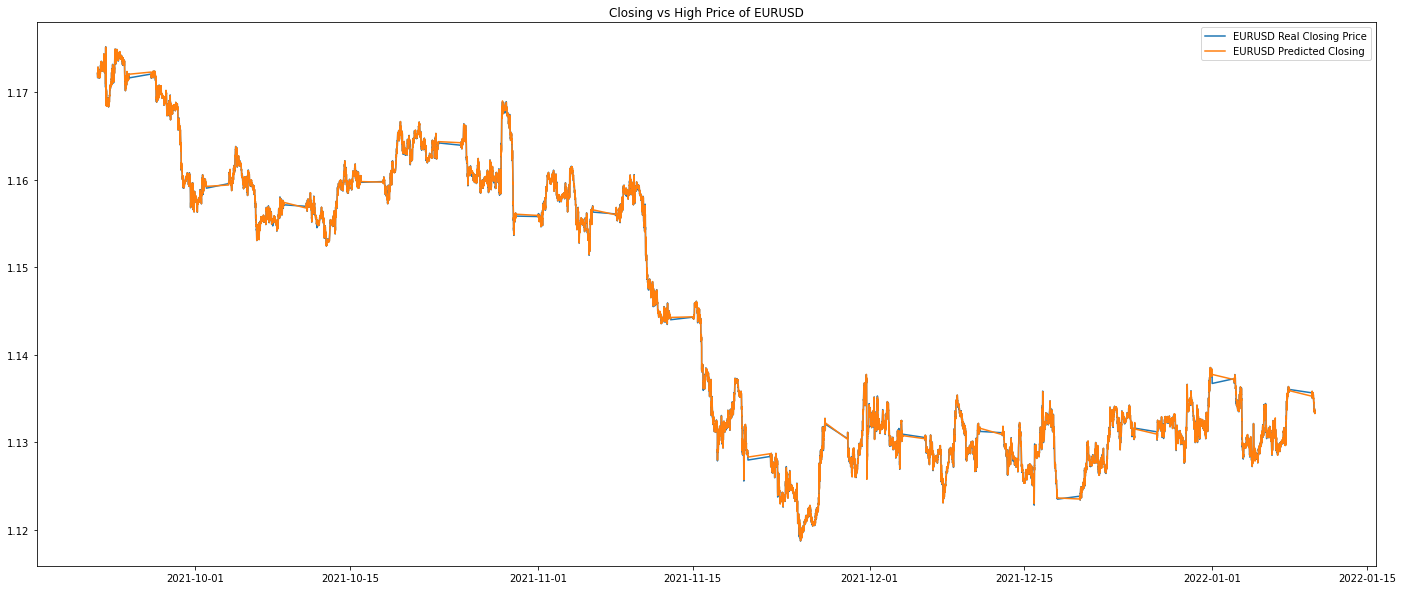

In [25]:
def plotLinearReg(y_test, predictions):
    predictions = pd.DataFrame(predictions, index=y_test.index)
    plt.figure(figsize=(24,10))
    plt.plot(y_test, label='{} Real Closing Price'.format(symbol))
    plt.plot(predictions, label='{} Predicted Closing'.format(symbol))
    plt.title('Closing vs High Price of {}'.format(symbol))
    plt.legend()
    plt.show()

plotLinearReg(y_test, predictions_lin)

In [156]:
def generate_signal(df_features, rates_frame, predictions):
    df_signal = pd.DataFrame(index=df_features.index)
    
    df_signal['predictions'] = predictions
    df_signal['predictions_5m'] = df_signal['predictions'].shift(1)
    df_signal['EMA_4h'] = TA.EMA(rates_frame, 48)
    df_signal['EMA_12h'] = TA.EMA(rates_frame, 144)

    df_signal['avg_price_30m'] = rates_frame['close'].rolling(window=6).mean().shift(1)
    df_signal['avg_price_4h'] = rates_frame['close'].rolling(window=48).mean().shift(1)

    df_signal['ratio_avg_price_30m_4h'] = df_signal['avg_price_30m'] / df_signal['avg_price_4h']

    df_signal['open'] = rates_frame['open']
    df_signal['open_5m'] = rates_frame['open'].shift(1)
    df_signal['close_5m'] = rates_frame['close'].shift(1)
    df_signal['high_5m'] = rates_frame['high'].shift(1)
    df_signal['low_5m'] = rates_frame['low'].shift(1)

    return df_signal

In [157]:
now = datetime.now() # current date and time
date_time = now.strftime("%m/%d/%Y %H:%M:%S")
print("date and time:",date_time)

date and time: 01/10/2022 17:35:33


In [158]:
model_filename = 'saved_model/MetaNgepet_{}_{}_LinearReg_Model.pkl'.format(symbol, timeframe)
pickle.dump(lin, open(model_filename, 'wb'))

scaler_filename = 'saved_scaler/MetaNgepet_{}_{}_LinearReg_Scaler.pkl'.format(symbol, timeframe)
pickle.dump(scaler, open(scaler_filename, 'wb'))

In [159]:
new_bars = 500

new_rates = get_price(symbol, timeframe, new_bars)
new_rates.tail()

,open,high,low,close,volume,spread
time,,,,,,
2022-01-10 12:15:00,1.13290,1.13331,1.13289,1.13318,153.0,10.0
2022-01-10 12:20:00,1.13315,1.13333,1.13298,1.13299,122.0,10.0
2022-01-10 12:25:00,1.13299,1.13316,1.13289,1.13302,106.0,10.0
2022-01-10 12:30:00,1.13302,1.13306,1.13255,1.13265,178.0,10.0
2022-01-10 12:35:00,1.13265,1.13268,1.13255,1.13255,25.0,11.0


In [160]:
opening= new_rates.loc['2022-01-10 08:45:00']['open']
print(opening)

1.13277


In [161]:
new_rates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 2022-01-06 18:55:00 to 2022-01-10 12:35:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    501 non-null    float64
 1   high    501 non-null    float64
 2   low     501 non-null    float64
 3   close   501 non-null    float64
 4   volume  501 non-null    float64
 5   spread  501 non-null    float64
dtypes: float64(6)
memory usage: 43.6 KB


In [162]:
df_signals = generate_features(new_rates)
df_signals.tail()

,open,open_5m,close_5m,high_5m,low_5m,volume_5m,spread_5m,avg_price_30m,avg_price_4h,avg_price_12h,...,return_30m,return_4h,return_12h,return_1d,return_avg_30m,return_avg_4h,return_avg_12h,return_avg_1d,EMA_4h,close
time,,,,,,,,,,,,,,,,,,,,,
2022-01-10 12:15:00,1.13290,1.13255,1.13290,1.13297,1.13251,216.0,10.0,1.132592,1.132980,1.133979,...,-0.000018,-0.000088,-0.002272,0.001202,-0.000003,-0.000002,-0.000016,0.000004,1.133079,1.13318
2022-01-10 12:20:00,1.13315,1.13290,1.13318,1.13331,1.13289,153.0,10.0,1.132672,1.132984,1.133962,...,0.000424,0.000177,-0.002122,0.001458,0.000071,0.000004,-0.000015,0.000005,1.133075,1.13299
2022-01-10 12:25:00,1.13299,1.13315,1.13299,1.13333,1.13298,122.0,10.0,1.132727,1.132989,1.133944,...,0.000291,0.000194,-0.002281,0.001458,0.000049,0.000004,-0.000016,0.000005,1.133073,1.13302
2022-01-10 12:30:00,1.13302,1.13299,1.13302,1.13316,1.13289,106.0,10.0,1.132807,1.132994,1.133927,...,0.000424,0.000221,-0.002114,0.001635,0.000071,0.000005,-0.000015,0.000006,1.133056,1.13265
2022-01-10 12:35:00,1.13265,1.13302,1.13265,1.13306,1.13255,178.0,10.0,1.132883,1.132991,1.133908,...,0.000406,-0.000150,-0.002519,0.001574,0.000068,-0.000003,-0.000017,0.000005,1.133035,1.13255


In [163]:
df_signals.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 212 entries, 2022-01-07 19:00:00 to 2022-01-10 12:35:00
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   open                       212 non-null    float64
 1   open_5m                    212 non-null    float64
 2   close_5m                   212 non-null    float64
 3   high_5m                    212 non-null    float64
 4   low_5m                     212 non-null    float64
 5   volume_5m                  212 non-null    float64
 6   spread_5m                  212 non-null    float64
 7   avg_price_30m              212 non-null    float64
 8   avg_price_4h               212 non-null    float64
 9   avg_price_12h              212 non-null    float64
 10  avg_price_1d               212 non-null    float64
 11  ratio_avg_price_30m_4h     212 non-null    float64
 12  ratio_avg_price_30m_12h    212 non-null    float64
 13  ratio_avg_pri

In [164]:
new_X = df_signals.drop('close', axis='columns')
new_y = df_signals.close

signal_scaled = scaler.transform(new_X)

In [165]:
# load the model from disk
loaded_model = pickle.load(open(model_filename, 'rb'))

new_predictions = loaded_model.predict(signal_scaled)

get_score(new_y, new_predictions)

RMSE: 0.000
MAE: 0.000
R^2: 0.978


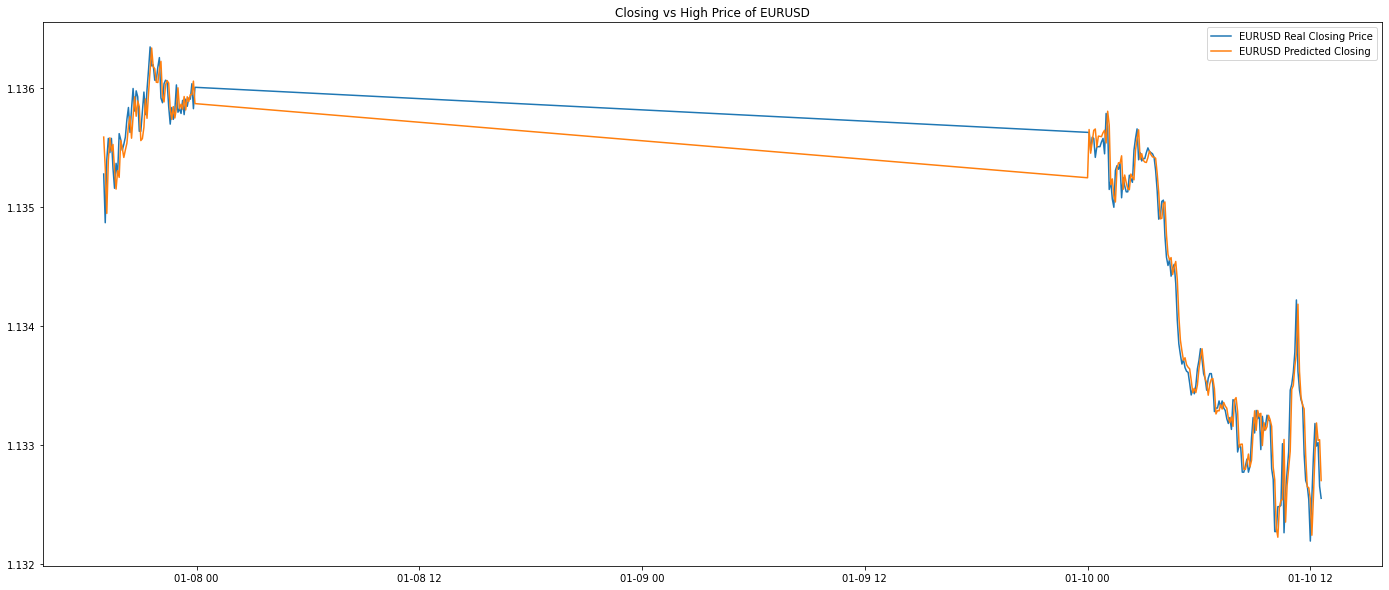

In [166]:
plotLinearReg(new_y, new_predictions)

In [167]:
df_model = generate_signal(df_signals, new_rates, new_predictions)
df_model.tail()

,predictions,predictions_5m,EMA_4h,EMA_12h,avg_price_30m,avg_price_4h,ratio_avg_price_30m_4h,open,open_5m,close_5m,high_5m,low_5m
time,,,,,,,,,,,,
2022-01-10 12:15:00,1.132927,1.132558,1.133079,1.133568,1.132592,1.132980,0.999657,1.13290,1.13255,1.13290,1.13297,1.13251
2022-01-10 12:20:00,1.133185,1.132927,1.133075,1.133560,1.132672,1.132984,0.999724,1.13315,1.13290,1.13318,1.13331,1.13289
2022-01-10 12:25:00,1.133038,1.133185,1.133073,1.133553,1.132727,1.132989,0.999768,1.13299,1.13315,1.13299,1.13333,1.13298
2022-01-10 12:30:00,1.133044,1.133038,1.133056,1.133540,1.132807,1.132994,0.999835,1.13302,1.13299,1.13302,1.13316,1.13289
2022-01-10 12:35:00,1.132700,1.133044,1.133035,1.133526,1.132883,1.132991,0.999905,1.13265,1.13302,1.13265,1.13306,1.13255


In [168]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 212 entries, 2022-01-07 19:00:00 to 2022-01-10 12:35:00
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   predictions             212 non-null    float64
 1   predictions_5m          211 non-null    float64
 2   EMA_4h                  212 non-null    float64
 3   EMA_12h                 212 non-null    float64
 4   avg_price_30m           212 non-null    float64
 5   avg_price_4h            212 non-null    float64
 6   ratio_avg_price_30m_4h  212 non-null    float64
 7   open                    212 non-null    float64
 8   open_5m                 212 non-null    float64
 9   close_5m                212 non-null    float64
 10  high_5m                 212 non-null    float64
 11  low_5m                  212 non-null    float64
dtypes: float64(12)
memory usage: 21.5 KB
